In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import *
import cv2
import numpy as np
from collections import Counter
from prettytable import PrettyTable

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
train_path = './chest_xray/train'
test_path = './chest_xray/test'
val_path = './chest_xray/val'

In [4]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))
    plt.suptitle(img_dir.split("/")[-1])
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx + 1)
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img, cmap='gray')

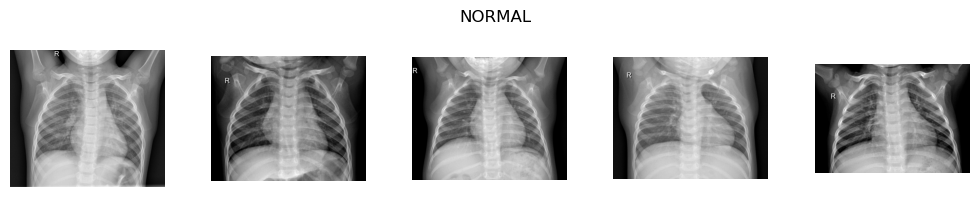

In [5]:
plot_images(train_path + '/NORMAL')

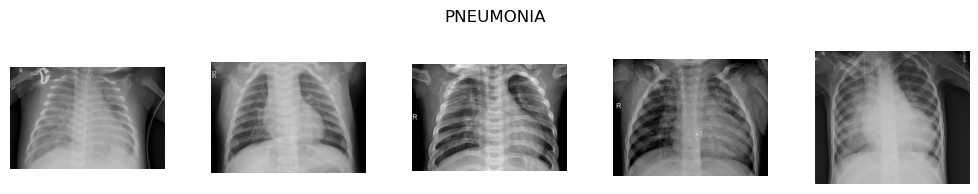

In [6]:
plot_images(train_path + '/PNEUMONIA')

In [7]:
def plot_bar_chart_diagram(path_data):
    dic = {}
    for file in os.listdir(path_data):
        if file == ".DS_Store":
            continue
        dem = 0
        for x in os.listdir(path_data + "/" + file):
            dem += 1
        dic[file] = dem
    print(dic)
    barlist = plt.bar(list(range(len(dic))),
                      list(dic.values()),
                      tick_label=list(dic.keys()))
    plt.show()

{'NORMAL': 1341, 'PNEUMONIA': 3875}


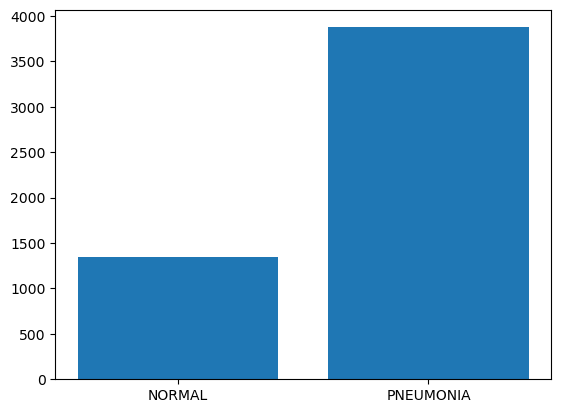

In [8]:
plot_bar_chart_diagram(train_path)

{'NORMAL': 234, 'PNEUMONIA': 390}


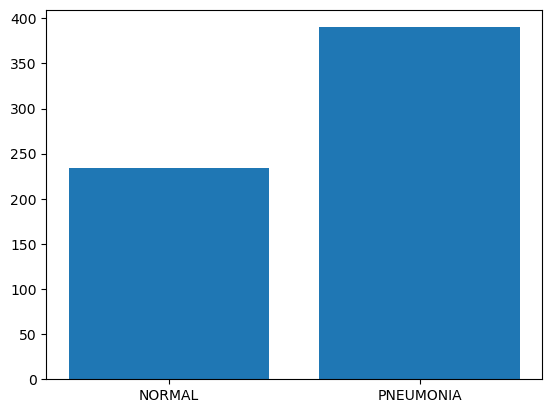

In [9]:
plot_bar_chart_diagram(test_path)

In [10]:
def load_images(img_dir):
    images = []
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs]
    for idx, img_path in enumerate(img_files):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (100, 100))
        images.append(img)
    return images

In [11]:
normalImages = load_images(train_path + '/NORMAL')
normalLabels = [0] * len(normalImages)
pneumoniaImages = load_images(train_path + '/PNEUMONIA')
pneumoniaLabels = [1] * len(pneumoniaImages)

trainX = normalImages + pneumoniaImages[:len(normalImages)]
trainY = normalLabels + pneumoniaLabels[:len(normalLabels)]

In [12]:
normalImages = load_images(test_path + '/NORMAL')
normalLabels = [0] * len(normalImages)
pneumoniaImages = load_images(test_path + '/PNEUMONIA')
pneumoniaLabels = [1] * len(pneumoniaImages)

testX = normalImages + pneumoniaImages#[:len(normalImages)]
testY = normalLabels + pneumoniaLabels#[:len(normalLabels)]

In [13]:
print((len(trainX), len(trainY), len(testX), len(testY)))

(2682, 2682, 624, 624)


In [14]:
trainX = np.array(trainX).reshape(2682, 10000)
testX = np.array(testX).reshape(624, 10000)

In [15]:
data = {
    'x_train': trainX,
    'x_test': testX,
    'y_train': trainY,
    'y_test': testY
}

In [16]:
# dimension of the data
trainX.shape, testX.shape

((2682, 10000), (624, 10000))

### stacking classifier

In [17]:
# Define the base classifiers
estimators = [
    ('logistic_regression', LogisticRegression(max_iter=10000)),
    ('svm', SVC(probability=True)),
    ('random_forest', RandomForestClassifier())
]


In [18]:
# Define the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=10000),
    stack_method='predict'
)


In [19]:
# Fit the stacking classifier on the training data
stacking_classifier.fit(trainX, trainY)

StackingClassifier(estimators=[('logistic_regression',
                                LogisticRegression(max_iter=10000)),
                               ('svm', SVC(probability=True)),
                               ('random_forest', RandomForestClassifier())],
                   final_estimator=LogisticRegression(max_iter=10000),
                   stack_method='predict')

In [20]:
# Make predictions on the testing data
predictions = stacking_classifier.predict(testX)

In [21]:
def print_metrics(y_test, predictions):
    table = PrettyTable()
    table.field_names = ["Metric", "Value"]
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='micro')
    recall = recall_score(y_test, predictions, average='micro')
    
    table.add_row(["Accuracy", accuracy])
    table.add_row(["Precision", precision])
    table.add_row(["Recall", recall])
    
    print(table)

In [22]:
print_metrics(data['y_test'], predictions)

+-----------+--------------------+
|   Metric  |       Value        |
+-----------+--------------------+
|  Accuracy | 0.8189102564102564 |
| Precision | 0.8189102564102564 |
|   Recall  | 0.8189102564102564 |
+-----------+--------------------+


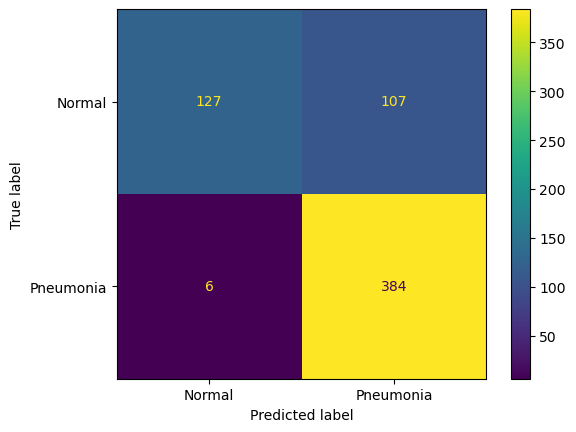

In [23]:
display(
    ConfusionMatrixDisplay(confusion_matrix(data['y_test'], predictions),
                           display_labels=['Normal', 'Pneumonia']).plot())

In [24]:
# Plot the ROC curve
y_prob = stacking_classifier.predict_proba(testX)
fpr, tpr, thresholds = roc_curve(data['y_test'], y_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

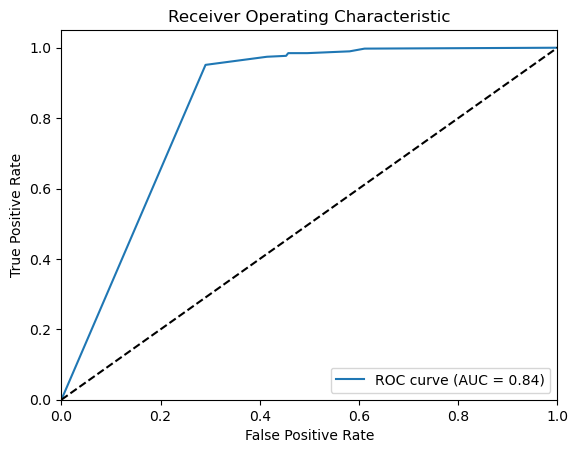

In [25]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### voting classifier

In [26]:
# Define the individual classifiers
classifier1 = LogisticRegression(max_iter=10000)
classifier2 = SVC(probability=True)
classifier3 = RandomForestClassifier()

In [27]:
# Define the voting classifier
voting_classifier = VotingClassifier(
    estimators=[('logistic_regression', classifier1),
                ('svm', classifier2),
                ('random_forest', classifier3)],
    voting='soft'
)

In [28]:
# Fit the voting classifier on the training data
voting_classifier.fit(trainX, trainY)

VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(max_iter=10000)),
                             ('svm', SVC(probability=True)),
                             ('random_forest', RandomForestClassifier())],
                 voting='soft')

In [29]:
# Make predictions on the testing data
y_pred = voting_classifier.predict(testX)

In [30]:
print_metrics(data['y_test'], y_pred)

+-----------+--------------------+
|   Metric  |       Value        |
+-----------+--------------------+
|  Accuracy | 0.8092948717948718 |
| Precision | 0.8092948717948718 |
|   Recall  | 0.8092948717948718 |
+-----------+--------------------+


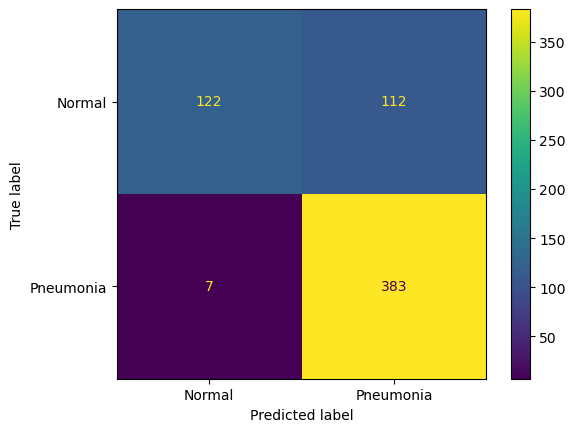

In [31]:
display(
    ConfusionMatrixDisplay(confusion_matrix(data['y_test'], y_pred),
                           display_labels=['Normal', 'Pneumonia']).plot())

In [32]:
# Plot the ROC curve
y_prob = voting_classifier.predict_proba(testX)
fpr, tpr, thresholds = roc_curve(data['y_test'], y_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

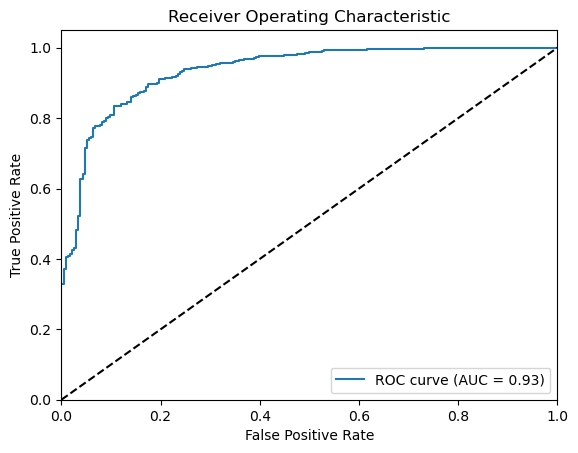

In [33]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Bagging classifier

In [34]:
# Define the base classifier
base_classifier = DecisionTreeClassifier()

In [35]:
# Define the bagging classifier
bagging_classifier = BaggingClassifier(
    base_classifier,
    n_estimators=10,
    max_samples=0.5,
    max_features=0.5,
    random_state=42
)

In [36]:
# Fit the bagging classifier on the training data
bagging_classifier.fit(trainX, trainY)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=0.5,
                  max_samples=0.5, random_state=42)

In [37]:
# Make predictions on the testing data
y_pred = bagging_classifier.predict(testX)

In [38]:
print_metrics(data['y_test'], y_pred)

+-----------+-------------------+
|   Metric  |       Value       |
+-----------+-------------------+
|  Accuracy | 0.782051282051282 |
| Precision | 0.782051282051282 |
|   Recall  | 0.782051282051282 |
+-----------+-------------------+


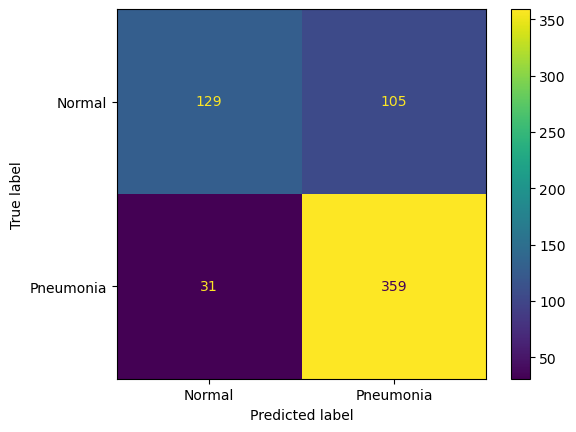

In [39]:
display(
    ConfusionMatrixDisplay(confusion_matrix(data['y_test'], y_pred),
                           display_labels=['Normal', 'Pneumonia']).plot())

In [40]:
# Plot the ROC curve
y_prob = bagging_classifier.predict_proba(testX)
fpr, tpr, thresholds = roc_curve(data['y_test'], y_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

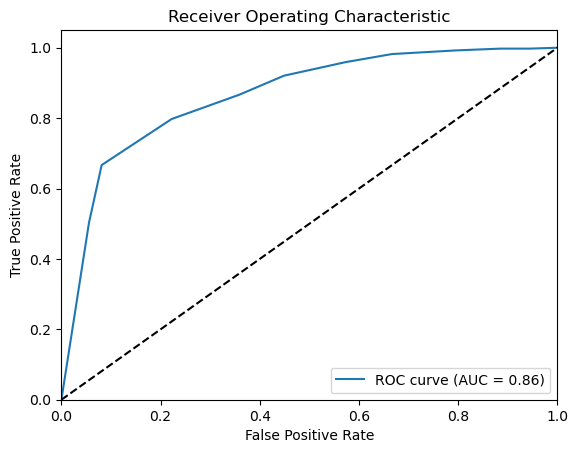

In [41]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()